In [75]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import warnings
warnings.filterwarnings("error")

import numpy as np
import matplotlib.pylab as plt

from utils import *

X_train, Y_train, X_val, Y_val, X_test, Y_test = load_data()
X_train_one,X_train_out = oneClass_data(X_train,Y_train,5)
X_test_one,X_test_out = oneClass_data(X_test,Y_test,5)

In [106]:
class Sequential(Module):
    """
    Sequential provides a way to plug layers together in a feed-forward manner.
    """
    def __init__(self):
        Module.__init__(self)
        self.layers = [] # layers contain all the layers in order
    
    def add(self, layer):
        self.layers.append(layer) # Add another layer at the end
    
    def size(self):
        return len(self.layers) # How many layers.
    def get_rho(self):
        try:
            return self.layers[1].rho_hat
        except:
            return 0
    def forward(self, _input):
        """
        Feed forward through all the layers, and return the output of the last layer
        """
        # self._inputs saves the input of each layer
        # self._inputs[i] is the input of i-th layer
        self._inputs = [_input]
        
        for m in self.layers:
            z = m.forward(self._inputs[-1])
            self._inputs.append(z)
        # The last element of self._inputs is the output of last layer
        self._output = self._inputs[-1]
        return self._output
    
    def backward(self, _gradOutput):
        """
        Backpropogate through all the layers using chain rule.
        """
        # self._gradInputs[i] is the gradient of loss w.r.t. the input of i-th layer
        self._gradInputs = [None] * (self.size() + 1)
        self._gradInputs[self.size()] = _gradOutput
        
        for i in range(self.size() - 1, -1, -1):
            z = self.layers[i].backward(self._inputs[i], self._gradInputs[i + 1])
            self._gradInputs[i] = z

        self._gradInput = self._gradInputs[0]
        return self._gradInput
    
    def parameters(self):
        """
        Return trainable parameters and its corresponding gradient in a nested list
        """
        params = []
        gradParams = []
        for m in self.layers:
            _p, _g = m.parameters()
            if _p is not None:
                params.append(_p)
                gradParams.append(_g)
        return params, gradParams
     
    def training(self):
        """
        Turn all the layers into training mode
        """
        Module.training(self)
        for m in self.layers:
            m.training()
    
    def evaluate(self):
        """
        Turn all the layers into evaluate mode
        """
        Module.evaluate(self)
        for m in self.layers:
            m.evaluate()

class FullyConnected(Module):
    """
    Fully connected layer
    """
    def __init__(self, inputSize, outputSize):
        Module.__init__(self)
        # Initalization
        stdv = 1. / np.sqrt(inputSize)
        
        self.weight = np.random.uniform(-stdv, stdv, (inputSize, outputSize))
        self.gradWeight = np.ndarray((inputSize, outputSize))
        self.bias = np.random.uniform(-stdv, stdv, outputSize)
        self.gradBias = np.ndarray(outputSize)
        
    def forward(self, _input):
        """
        output = W * input + b
        
        _input:
        N x inputSize matrix
        
        """
        params,_ = self.parameters()
        W = params[0]
        b = params[1]
        self._output = np.dot(_input, W) + b
        return self._output
    
    def backward(self, _input, _gradOutput):
        """
        _input:
        N x inputSize matrix
        _gradOutput:
        N x outputSize matrix
        """
        params,_ = self.parameters()
        W = params[0]    
        self._gradInput = np.dot(_gradOutput, W.T)
        
        self.gradWeight = np.dot(_input.T, _gradOutput) / _input.shape[0]
        self.gradBias = np.mean(_gradOutput, axis = 0)
        return self._gradInput
        
    def parameters(self):
        """
        Return weight and bias and their g
        """
        return [self.weight, self.bias], [self.gradWeight, self.gradBias] 

class Logistic(Module):
    """
    Logistic activation, not trainable.
    """
    def __init__(self, beta = 0, rho = 0.05):
        Module.__init__(self)
        self.beta = beta
        self.rho = rho
        return

    def forward(self, _input):
        """
        input:
        _input: 
        size of N * inputsize
        
        output:
        self._output:
        size of N * inputsize
        """
        try:
            self._output = 1 / (1 + np.exp(-_input))
        except:
            self._output = np.exp(_input) / (1 + np.exp(_input))

        if self.beta != 0:
            self.rho_hat = np.mean(self._output, axis = 0)
        return self._output
    
    def backward(self, _input, _gradOutput):
        if self.beta != 0:
            KL_grad = self.beta * (-(self.rho / self.rho_hat) + (1 - self.rho) / (1 - self.rho_hat))
        else:
            KL_grad = 0 
        
        a = self._output
        
        self._gradInput = (_gradOutput + KL_grad) * a * (1 - a)
        return self._gradInput
        
    def parameters(self):
        return None, None
    
class Dropout(Module):
    """
    A dropout layer
    """
    def __init__(self, p = 0.5):
        Module.__init__(self)
        self.p = p #self.p is the drop rate, if self.p is 0, then it's a identity layer
        
    def forward(self, _input):
        if self.train:
            p = self.p
            self.mask = np.random.choice(2, _input.shape[1], p = [p , 1 - p]) / (1 - p)

            self._output = self.mask * _input
        else:
            self._output = _input
        # Need to take care of training mode and evaluation mode
        return self._output
    
    def backward(self, _input, _gradOutput):
        if self.train:
            self._gradInput = self.mask * _gradOutput
        else:
            self._gradInput = _gradOutput
        return self._gradInput
    
    def parameters(self):
        """
        No trainable parameters.
        """
        return None, None

In [114]:
class Loss(object):
    def __init__(self):
        return
    @staticmethod
    def KL_divergence(y, rho):
        x = rho
        return x * np.log(x / y) + (1 - x) * np.log((1 - x) / (1 - y))
        
    def forward(self, _input, _label, rho_hat, beta = 1, rho = 0.1):
        """
        Softmax and cross entropy loss layer. Should return a scalar, since it's a
        loss. (It's almost identical to what in hw2)

        _input: N x C
        _labels: N x C, one-hot

        Returns: loss (scalar)
        """
        square_loss = np.sum((_input - _label) ** 2, axis = 1).mean() / 2
        if beta != 0:
            KL = beta * np.sum(self.KL_divergence(rho_hat,rho))
        else:
            KL = 0
        self._output = square_loss + KL
        return self._output
    
    def backward(self, _input, _label):
        self._gradInput =  _input - _label
        return self._gradInput

In [115]:
def build_autoencoder(NUM_FEATURES, HIDDEN_UNITS, dropout = 0.5):
    """
    Build the model:
    input_size: the dimension of input data
    hidden_size: the dimension of hidden vector
    """
    model = Sequential()
    model.add(FullyConnected(NUM_FEATURES,HIDDEN_UNITS))
    model.add(Logistic(beta = 1))
    model.add(FullyConnected(HIDDEN_UNITS, NUM_FEATURES))
    model.add(Logistic())

    return model
def runTrainVal(X,model,Xval,trainopt, crit):
    """
    Run the train + evaluation on a given train/val partition
    trainopt: various (hyper)parameters of the training procedure
    During training, choose the model with the lowest validation error. (early stopping)
    """
    
    eta = trainopt['eta']
    
    N = X.shape[0] # number of data points in X
    
    # Save the model with lowest validation error
    minValError = np.inf
    saved_model = None
    
    shuffled_idx = np.random.permutation(N)
    start_idx = 0
    for iteration in range(trainopt['maxiter']):
        if iteration % int(trainopt['eta_frac'] * trainopt['maxiter']) == 0:
            eta *= trainopt['etadrop']
        # form the next mini-batch
        stop_idx = min(start_idx + trainopt['batch_size'], N)
        batch_idx = range(N)[int(start_idx):int(stop_idx)]
        bX = X[shuffled_idx[batch_idx],:]

        x_hat = model.forward(bX)
        
        rho = model.get_rho()
        loss = crit.forward(x_hat, bX, beta=1, rho = .05,rho_hat=rho)
        # print(loss)
        delta_ = crit.backward(x_hat, bX)
        model.backward(delta_)
        
        # Update the data using 
        params, gradParams = model.parameters()
        sgdmom(params, gradParams, eta, weight_decay = trainopt['lambda'])    
        start_idx = stop_idx % N
        
        if (iteration % trainopt['display_iter']) == 0:
            #compute train and val error; multiply by 100 for readability (make it percentage points)
            print('{:8} batch loss: {:.3f}'.format(iteration, loss))
    return None

In [116]:
trainopt = {
    'eta': .1,   # initial learning rate
    'maxiter': 5000,   # max number of iterations (updates) of SGD
    'display_iter': 1000,  # display batch loss every display_iter updates
    'batch_size': 256,  
    'etadrop': .5, # when dropping eta, multiply it by this number (e.g., .5 means halve it)
    'eta_frac': .25  #
}
lambdas = np.array([0.001])
NUM_FEATURES = 28 * 28
HIDDEN_UNITS = 196
for lambda_ in lambdas:
    trainopt['lambda'] = lambda_
    model = build_autoencoder(NUM_FEATURES, HIDDEN_UNITS)
    crit = Loss()
    # -- model trained on large train set
    runTrainVal(X_train_one, model, X_test_one, trainopt, crit)

       0 batch loss: 93.183
    1000 batch loss: 12.389
    2000 batch loss: 10.037
    3000 batch loss: 8.832
    4000 batch loss: 8.216


In [123]:
model.evaluate()

bX1 = X_test_one
x_hat1 = model.forward(bX1)

loss1 = np.sum((x_hat1 - bX1) ** 2, axis = 1)

bX2 = X_test_out
x_hat2 = model.forward(bX2)
loss2 = np.sum((x_hat2 - bX2) ** 2, axis = 1)

for t in np.arange(32.5,32.6,0.2):
    tp = 100 * np.sum(loss1 <= t) / bX1.shape[0]
    fn = 100 * np.sum(loss1 > t) / bX1.shape[0]
    
    fp = 100 * np.sum(loss2 < t) / bX2.shape[0]
    p = 100 * tp / (tp + fp)
    r = 100 * tp / (tp + fn)
    f = (2 * p * r) / (p + r)
    print(p,r,f,fn,fp,np.sum(loss1 <= t),np.sum(loss1 > t),np.sum(loss2 <= t),np.sum(loss2 > t))

68.8087652498 98.0941704036 80.8822051841 1.90582959641 44.4664031621 875 17 4050 5058


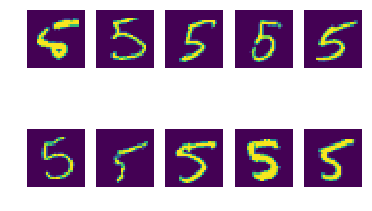

In [124]:
#display original images
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(bX1[i].reshape(28, 28))
    plt.axis('off')
plt.show()

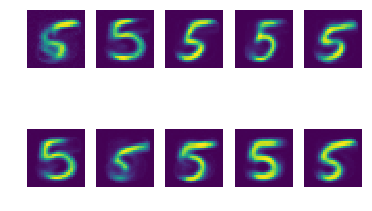

In [125]:
#display reconstructed images
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_hat1[i].reshape(28, 28))
    plt.axis('off')
plt.show()

In [47]:
params,_ = model.parameters()
W = params[0][0]

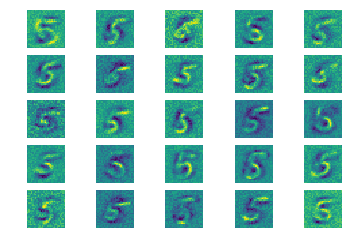

In [122]:
def visualizeW(W):
    w = W / np.sqrt(np.sum(W ** 2, axis = 0))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(w[:,i].reshape(28, 28))
        plt.axis('off')
    plt.show()
visualizeW(W1)